In [12]:
import numpy as np
import seaborn as sns
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, matthews_corrcoef, f1_score, precision_score, recall_score
import pandas as pd
import missingno as msno

## methods

In [55]:
def find_zscore_outliers(df, col_name, bottom_threshold=-8, top_threshold=8):
  global zscore_outliers
  global zscore_non_outliers

  mean = np.mean(df[col_name])
  mad = df[col_name].mad()

  zscore_outliers = [x for x in df[col_name] if (
    ((x-mean)/mad < bottom_threshold) or ((x-mean)/mad > top_threshold))]
  zscore_non_outliers = [x for x in df[col_name] if (
    ((x-mean)/mad < top_threshold) & ((x-mean)/mad > bottom_threshold))]

  outlier_filtered_zscore = df.loc[df[col_name].isin(zscore_outliers)]
  filtered_zscore = df.loc[df[col_name].isin(zscore_non_outliers)]

  final_outliers.append(outlier_filtered_zscore.index)

In [56]:
def get_outlier_count(outliers) :
  count = 0
  unique_outliers_manual = []
  for outlier_list in outliers:
    for outlier in outlier_list:
      unique_outliers_manual.append(outlier)
      count = count + 1
  # total number of outliers found
  print("total number of outliers: " + str(count))
  unique_outliers_manual = np.unique(unique_outliers_manual)
  # number of unique outlier indexes
  print("number of unique outliers: " + str(unique_outliers_manual.size))
  print(unique_outliers_manual)

In [186]:
# get a list of models to evaluate
def get_models():
 models = dict()
 models['knn'] = KNeighborsClassifier()
 models['cart'] = DecisionTreeClassifier()
 models['rf'] = RandomForestClassifier()
 models['et'] = ExtraTreesClassifier()
 models['l_svm'] = LinearSVC()
 models['svm'] = SVC()
 models['bayes'] = GaussianNB()
 models['lr'] = LogisticRegression(max_iter=1000)
 models['en'] = LogisticRegression(penalty = 'elasticnet', solver='saga', l1_ratio = 0.5, max_iter=1000)
 models['lda'] = LinearDiscriminantAnalysis()
 return models

In [57]:
def performance_metrics(model, y_test, y_pred):
  # [ TN / FN ]
  # [ FP / TP ]
  print("=== Confusion Matrix ===")
  print(confusion_matrix(y_test, y_pred))
  print("=== Classification Report ===")
  print(classification_report(y_test, y_pred))
  cv_score = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
  print("=== Mean AUC Score ===")
  print("%.3f" % cv_score.mean())
  print("=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===")
  print("%.3f" % cohen_kappa_score(y_test, y_pred))
  print("=== F1 Score (best value at 1 and worst score at 0) ===")
  print("%.3f" % f1_score(y_test, y_pred))
  print("=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===")
  print("%.3f" % matthews_corrcoef(y_test, y_pred))
  print("=== Sensitivity ===")
  print("%.3f" % recall_score(y_test, y_pred, pos_label=1))
  print("=== Specificity ===")
  print("%.3f" % recall_score(y_test, y_pred, pos_label=0))

In [58]:
# TODO: plot a different graph as there's only two prediction values (0, 1) where 0 is no tumour progression and 1 is. ROC curves.

# def plot_graph(y_pred):
  # plt.?(y_test, y_pred)

  # # include regression line
  # gradient, intercept = np.polyfit(y_test, y_pred, 1)
  # plt.plot(y_test, gradient*y_test + intercept, color='r', linewidth=2)

  # plt.xlabel("Actual")
  # plt.ylabel("Predicted")
  # plt.ticklabel_format(style='plain')
  # plt.show()

# M1: RPPA protein data.
Measured from primary tumours from TCGA HNSC participants. Prediction on the PFI cancer-related outcome.

### loading data

In [171]:
c_df = pd.read_csv("/content/sample_data/clinical.txt", sep="\t")
c_df.set_index("participant", inplace=True)
c_df

,female,histology,age.at.diagnosis,ethnicity,race,positive.lymphnodes,stage,tnm.m.category,tnm.n.category,tnm.t.category,...,monocyte.infiltration,neutrophil.infiltration,necrosis.percent,normal.cells.percent,stromal.cells.percent,tumor.cells.percent,pfi,pfi.time,dfi,dfi.time
participant,,,,,,,,,,,,,,,,,,,,,
5557,True,head & neck squamous cell carcinoma,41,hispanic or latino,NaN,1.0,stage iii,NaN,n1,t1,...,NaN,NaN,2,0.0,50.0,48,0,623,NaN,NaN
5559,False,head & neck squamous cell carcinoma,71,not hispanic or latino,white,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0.0,15.0,85,1,1614,NaN,NaN
6871,False,head & neck squamous cell carcinoma,75,NaN,white,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,0.0,19.0,80,1,108,NaN,NaN
4727,False,head & neck squamous cell carcinoma,56,not hispanic or latino,white,0.0,stage iva,NaN,n0,t4,...,NaN,NaN,0,0.0,20.0,80,0,1560,NaN,NaN
6021,True,head & neck squamous cell carcinoma,63,not hispanic or latino,white,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0.0,15.0,85,1,276,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827,True,head & neck squamous cell carcinoma,55,not hispanic or latino,white,NaN,stage i,NaN,n0,t1,...,NaN,NaN,1,0.0,30.0,69,0,568,0.0,568.0
7591,False,head & neck squamous cell carcinoma,62,not hispanic or latino,white,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0.0,15.0,85,0,622,NaN,NaN
7592,False,head & neck squamous cell carcinoma,57,not hispanic or latino,american indian or alaska native,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0.0,15.0,85,0,1143,NaN,NaN


<Axes: >

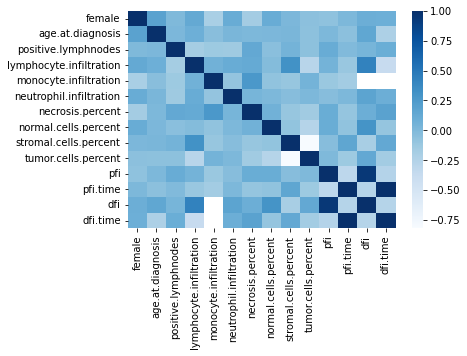

In [172]:
# features with low correlation to the outcome class should NOT just be removed
sns.heatmap(c_df.corr(), cmap="Blues")

In [173]:
# features of over 30% missing should be considered for removal
c_df.isnull().sum() / len(c_df.index) * 100

female                      0.000000
histology                   0.000000
age.at.diagnosis            0.000000
ethnicity                   4.245283
race                        1.886792
positive.lymphnodes        19.811321
stage                       5.660377
tnm.m.category             89.150943
tnm.n.category             16.981132
tnm.t.category              3.773585
lymphocyte.infiltration    69.339623
monocyte.infiltration      76.886792
neutrophil.infiltration    73.584906
necrosis.percent            0.000000
normal.cells.percent        1.415094
stromal.cells.percent       0.943396
tumor.cells.percent         0.000000
pfi                         0.000000
pfi.time                    0.000000
dfi                        81.132075
dfi.time                   81.132075
dtype: float64

<Axes: >

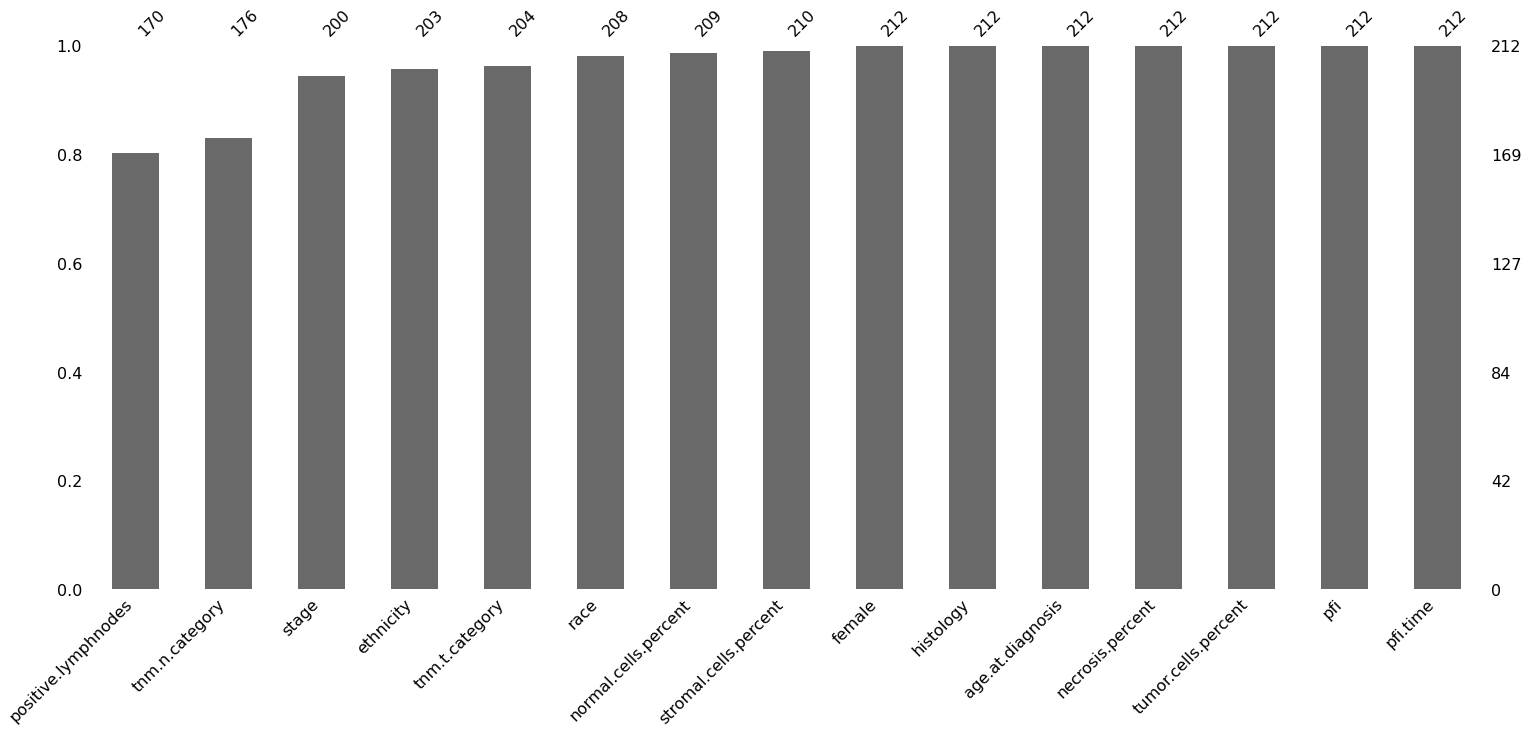

In [174]:
c2_df = c_df.drop(['tnm.m.category', 'lymphocyte.infiltration', 'monocyte.infiltration', 'neutrophil.infiltration', 'dfi', 'dfi.time'], axis=1)
c2_df
msno.bar(c2_df, sort='ascending')

<Axes: >

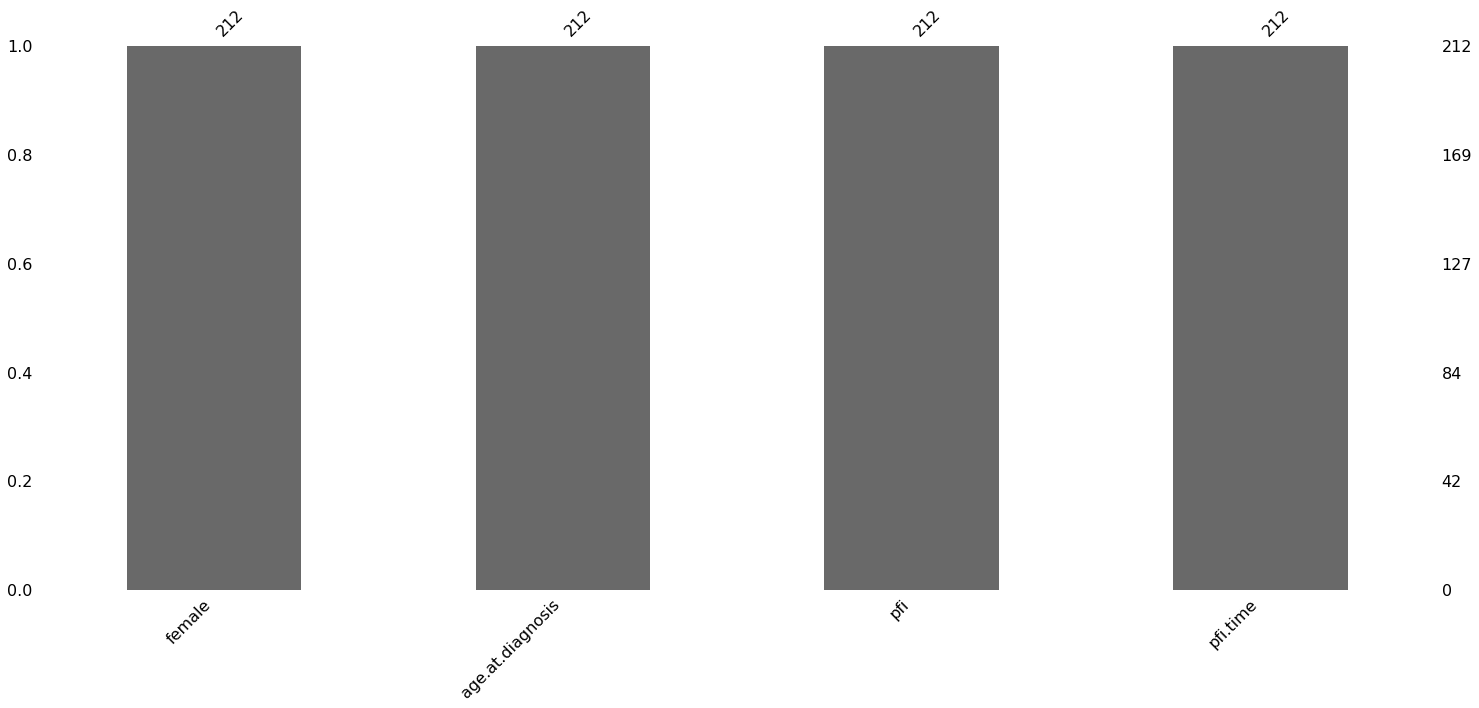

In [175]:
# features that are easily observable at clinical visits should be observed
c3_df = pd.DataFrame(data=[c_df.female, c_df['age.at.diagnosis'], c_df.pfi, c_df['pfi.time']])
msno.bar(c3_df.transpose(), sort='ascending')

In [176]:
p_df = pd.read_csv("/content/sample_data/protein.txt", sep="\t")
p_df
# each column is a tissue sample
# each row is a protein
# therefore each cell represents the level of the specific protein in that specific tissue sample.

,Sample REF,4074,4078,5149,5151,5152,5153,5555,5556,5557,...,6517,6823,6824,6825,6826,6827,7591,7592,7630,7632
0,14-3-3_epsilon,-0.975455,-1.023625,-0.656239,-0.417939,-0.771338,-1.177445,-0.899290,-1.307023,-0.681439,...,-1.131555,-0.717231,-1.192139,-0.927191,-1.077519,-1.064459,-1.126745,-0.427520,-1.032277,-1.209418
1,4E-BP1,-0.344284,0.335990,1.112516,1.837359,1.386950,0.458458,1.175845,0.825999,0.817223,...,0.540442,1.461922,1.010899,0.964098,1.401341,1.350660,0.314136,1.134611,0.339897,1.311902
2,4E-BP1_pS65,0.461891,-0.042486,0.524127,0.363827,0.059264,0.057335,0.376164,0.859202,0.178751,...,0.501993,0.780081,0.901885,0.987874,0.794332,0.594877,0.097680,0.219370,0.637518,0.311428
3,4E-BP1_pT37T46,1.795396,1.065434,0.412476,0.262011,0.576787,0.889808,1.122129,2.140152,-0.748593,...,1.866276,2.346631,1.179546,2.144487,1.866788,1.951218,0.796896,0.361095,0.057010,1.582886
4,4E-BP1_pT70,1.763210,0.595061,1.085620,1.287822,0.821192,0.445702,0.987013,1.190538,0.955448,...,0.915176,1.296934,0.894225,1.199529,0.833058,0.753732,0.577806,1.337440,0.691993,1.480586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,p53,0.459285,0.071299,0.577707,0.293831,0.010363,-0.523405,0.364286,-0.529587,-0.221350,...,0.053364,-0.018750,0.316054,-0.399878,-0.024031,0.079387,-0.830358,0.434107,1.049696,-0.920807
156,p63,1.816838,2.852411,2.276514,2.273316,1.938218,2.098402,2.751934,1.691012,0.058433,...,1.348757,1.976594,1.380697,1.335047,1.175178,1.073061,1.391248,1.265377,1.563363,1.698271
157,p70S6K,0.191172,0.484189,-0.102408,0.230295,1.059708,0.849870,0.263214,-0.288981,0.070605,...,0.697111,0.380837,0.794512,0.726010,0.563840,0.682962,0.585046,-0.796813,-0.033292,0.300683
158,p70S6K_pT389,-2.191290,-2.548276,-2.401650,-2.180772,-2.069344,-2.577867,-2.683242,-2.134266,-2.219878,...,-2.560017,-2.390717,-2.703487,-2.558751,-2.346810,-2.253784,-1.943766,-2.662181,-2.834331,-2.596767


### filtering input data

In [177]:
# samples = ['female', 'age.at.diagnosis']
pfi_df = pd.DataFrame(data=c_df.pfi)
# p_df = c_df.dropna(subset=['pfi'])
# X = p_df[samples]
# print(X.head)
print(pfi_df.head)

<bound method NDFrame.head of              pfi
participant     
5557           0
5559           1
6871           1
4727           0
6021           1
...          ...
6827           0
7591           0
7592           0
7630           0
7632           0

[212 rows x 1 columns]>


In [178]:
# make index the participant number
p_df.set_index("Sample REF", inplace=True)
transpose_df = p_df.transpose()
transpose_df

Sample REF,14-3-3_epsilon,4E-BP1,4E-BP1_pS65,4E-BP1_pT37T46,4E-BP1_pT70,53BP1,ACC1,ACC_pS79,AMPK_alpha,AMPK_pT172,...,p27,p27_pT157,p27_pT198,p38_MAPK,p38_pT180_Y182,p53,p63,p70S6K,p70S6K_pT389,p90RSK_pT359_S363
4074,-0.975455,-0.344284,0.461891,1.795396,1.763210,0.940777,2.529120,-0.673478,1.312644,-0.470337,...,-1.154002,1.252789,0.107269,0.516851,0.000823,0.459285,1.816838,0.191172,-2.191290,-0.743105
4078,-1.023625,0.335990,-0.042486,1.065434,0.595061,1.315773,2.119877,-0.878761,1.848433,2.194422,...,-1.470977,0.400928,0.155596,1.030774,1.941106,0.071299,2.852411,0.484189,-2.548276,-0.337144
5149,-0.656239,1.112516,0.524127,0.412476,1.085620,1.450957,1.806726,-1.032176,0.710373,1.551747,...,-1.544591,0.740280,-0.221206,0.563064,0.724724,0.577707,2.276514,-0.102408,-2.401650,-1.125616
5151,-0.417939,1.837359,0.363827,0.262011,1.287822,0.978116,2.832971,-0.122219,1.584088,1.813148,...,-1.048806,0.786717,-0.091238,0.786525,0.735234,0.293831,2.273316,0.230295,-2.180772,-1.328046
5152,-0.771338,1.386950,0.059264,0.576787,0.821192,0.813838,3.509105,-0.082333,1.688436,2.157730,...,-1.640419,0.731234,-0.127136,0.876586,0.974012,0.010363,1.938218,1.059708,-2.069344,-1.370619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827,-1.064459,1.350660,0.594877,1.951218,0.753732,2.121608,2.212484,-0.415407,0.638948,2.200436,...,-1.000700,0.627360,0.032024,0.322412,-0.225979,0.079387,1.073061,0.682962,-2.253784,-0.697415
7591,-1.126745,0.314136,0.097680,0.796896,0.577806,1.508773,1.437521,-1.389119,0.784970,1.625661,...,-0.931093,0.602038,0.186682,0.420839,0.201012,-0.830358,1.391248,0.585046,-1.943766,-1.104969
7592,-0.427520,1.134611,0.219370,0.361095,1.337440,0.621593,1.228141,-0.695001,1.744509,1.091202,...,-0.154663,0.820668,0.200029,0.943140,1.590219,0.434107,1.265377,-0.796813,-2.662181,-0.738091
7630,-1.032277,0.339897,0.637518,0.057010,0.691993,1.332849,2.128707,-0.870570,1.461211,2.233556,...,-1.608198,0.178051,-0.171085,0.786240,0.230017,1.049696,1.563363,-0.033292,-2.834331,-0.786704


In [179]:
# merge clinical pfi result and protein data
merged_df = transpose_df.merge(pfi_df, how="inner", on=transpose_df.index)
merged_df.set_index("key_0", inplace=True)
merged_df

,14-3-3_epsilon,4E-BP1,4E-BP1_pS65,4E-BP1_pT37T46,4E-BP1_pT70,53BP1,ACC1,ACC_pS79,AMPK_alpha,AMPK_pT172,...,p27_pT157,p27_pT198,p38_MAPK,p38_pT180_Y182,p53,p63,p70S6K,p70S6K_pT389,p90RSK_pT359_S363,pfi
key_0,,,,,,,,,,,,,,,,,,,,,
4074,-0.975455,-0.344284,0.461891,1.795396,1.763210,0.940777,2.529120,-0.673478,1.312644,-0.470337,...,1.252789,0.107269,0.516851,0.000823,0.459285,1.816838,0.191172,-2.191290,-0.743105,0
4078,-1.023625,0.335990,-0.042486,1.065434,0.595061,1.315773,2.119877,-0.878761,1.848433,2.194422,...,0.400928,0.155596,1.030774,1.941106,0.071299,2.852411,0.484189,-2.548276,-0.337144,1
5149,-0.656239,1.112516,0.524127,0.412476,1.085620,1.450957,1.806726,-1.032176,0.710373,1.551747,...,0.740280,-0.221206,0.563064,0.724724,0.577707,2.276514,-0.102408,-2.401650,-1.125616,1
5151,-0.417939,1.837359,0.363827,0.262011,1.287822,0.978116,2.832971,-0.122219,1.584088,1.813148,...,0.786717,-0.091238,0.786525,0.735234,0.293831,2.273316,0.230295,-2.180772,-1.328046,0
5152,-0.771338,1.386950,0.059264,0.576787,0.821192,0.813838,3.509105,-0.082333,1.688436,2.157730,...,0.731234,-0.127136,0.876586,0.974012,0.010363,1.938218,1.059708,-2.069344,-1.370619,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827,-1.064459,1.350660,0.594877,1.951218,0.753732,2.121608,2.212484,-0.415407,0.638948,2.200436,...,0.627360,0.032024,0.322412,-0.225979,0.079387,1.073061,0.682962,-2.253784,-0.697415,0
7591,-1.126745,0.314136,0.097680,0.796896,0.577806,1.508773,1.437521,-1.389119,0.784970,1.625661,...,0.602038,0.186682,0.420839,0.201012,-0.830358,1.391248,0.585046,-1.943766,-1.104969,0
7592,-0.427520,1.134611,0.219370,0.361095,1.337440,0.621593,1.228141,-0.695001,1.744509,1.091202,...,0.820668,0.200029,0.943140,1.590219,0.434107,1.265377,-0.796813,-2.662181,-0.738091,0


In [180]:
# merged_df.isnull().sum() / len(merged_df.index) * 100

In [181]:
# input
X = merged_df.drop('pfi', axis=1)
print(X)
# to predict
y = merged_df.pfi
print(y)

       14-3-3_epsilon    4E-BP1  4E-BP1_pS65  4E-BP1_pT37T46  4E-BP1_pT70  \
key_0                                                                       
4074        -0.975455 -0.344284     0.461891        1.795396     1.763210   
4078        -1.023625  0.335990    -0.042486        1.065434     0.595061   
5149        -0.656239  1.112516     0.524127        0.412476     1.085620   
5151        -0.417939  1.837359     0.363827        0.262011     1.287822   
5152        -0.771338  1.386950     0.059264        0.576787     0.821192   
...               ...       ...          ...             ...          ...   
6827        -1.064459  1.350660     0.594877        1.951218     0.753732   
7591        -1.126745  0.314136     0.097680        0.796896     0.577806   
7592        -0.427520  1.134611     0.219370        0.361095     1.337440   
7630        -1.032277  0.339897     0.637518        0.057010     0.691993   
7632        -1.209418  1.311902     0.311428        1.582886     1.480586   

In [182]:
# analyse how imbalanced the PFI class is
y.value_counts()

0    118
1     94
Name: pfi, dtype: int64

### anomaly dectection

In [183]:
final_outliers = []
global filtered_zscore
filtered_zscore = merged_df.copy()

for i in filtered_zscore.columns:
    # skip the PFI column
    if i == filtered_zscore.columns[(len(filtered_zscore.columns)-1)]:
      continue;
    else:
      # method removes outliers from global variable 'filtered_zscore' so do not
      # need to drop any rows here
      find_zscore_outliers(filtered_zscore, i)

final_outliers
get_outlier_count(final_outliers)

total number of outliers: 22
number of unique outliers: 14
['4725' '4726' '4728' '4730' '4741' '5326' '5434' '5977' '5979' '6012'
 '6222' '6225' '6933' '6960']


## models

In [184]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

In [185]:
# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

In [187]:
def evaluate_model(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=1)
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, error_score='raise')
 return scores

In [188]:
from numpy import mean
from numpy import std
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

>lr 0.554 (0.100)
>lda 0.553 (0.104)


### initial feature selection

In [46]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

### LinearSVC

In [77]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline(
    [
        ("scaling", MinMaxScaler()),
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", "passthrough"),
        ("classify", LinearSVC(dual=False, max_iter=10000)),
    ]
)

N_FEATURES_OPTIONS = [2, 4, 8, 16]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        "reduce_dim": [PCA(iterated_power=7)],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS,
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS,
    },
]

grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
grid.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('scaling', MinMaxScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify',
                                        LinearSVC(dual=False,
                                                  max_iter=10000))]),
             n_jobs=1,
             param_grid=[{'classify__C': [1, 10, 100, 1000],
                          'reduce_dim': [PCA(iterated_power=7)],
                          'reduce_dim__n_components': [2, 4, 8, 16]},
                         {'classify__C': [1, 10, 100, 1000],
                          'reduce_dim': [SelectKBest(k=2,
                                                     score_func=<function mutual_info_classif at 0x7fe12d1753a0>)],
                          'reduce_dim__k': [2, 4, 8, 16]}])

[[[0.55658915 0.53809524 0.54717608 0.5145072 ]
  [0.55658915 0.53809524 0.54717608 0.5145072 ]]

 [[0.55658915 0.54285714 0.54717608 0.5145072 ]
  [0.55658915 0.54285714 0.54717608 0.5145072 ]]

 [[0.55669989 0.53311185 0.50908084 0.49545958]
  [0.55681063 0.52369878 0.50908084 0.4910299 ]]

 [[0.55681063 0.52834994 0.50431894 0.4910299 ]
  [0.55681063 0.52834994 0.50431894 0.4910299 ]]]


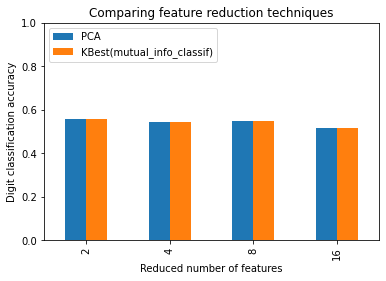

In [78]:
mean_scores = np.array(grid.cv_results_["mean_test_score"])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
print(mean_scores)
# select score for best C
mean_scores = mean_scores.max(axis=0)
# create a dataframe to ease plotting
reducer_labels = ["PCA", "KBest(mutual_info_classif)"]

mean_scores = pd.DataFrame(
    mean_scores.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
)

ax = mean_scores.plot.bar()
ax.set_title("Comparing feature reduction techniques")
ax.set_xlabel("Reduced number of features")
ax.set_ylabel("Digit classification accuracy")
ax.set_ylim((0, 1))
ax.legend(loc="upper left")

plt.show()

In [49]:
grid.cv_results_["mean_test_score"]

array([0.55658915, 0.53809524, 0.54717608,        nan,        nan,
              nan, 0.55658915, 0.53809524, 0.54717608,        nan,
              nan,        nan, 0.56135105, 0.5427464 , 0.5234773 ,
              nan,        nan,        nan, 0.54717608, 0.52414175,
       0.48106312,        nan,        nan,        nan, 0.55669989,
       0.53311185, 0.50908084, 0.55681063, 0.52369878, 0.50908084,
       0.55681063, 0.52834994, 0.50431894, 0.54728682, 0.49003322,
       0.48516058])

### RandomForest

In [166]:
from sklearn.ensemble import RandomForestClassifier

# default is bootstrap set to True
M1_2 = RandomForestClassifier(random_state=0)
M1_2.fit(X_train, y_train)
M1_2_y_pred = M1_2.predict(X_test)
performance_metrics(M1_2, y_test, M1_2_y_pred)

=== Confusion Matrix ===
[[18  6]
 [14  5]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.56      0.75      0.64        24
           1       0.45      0.26      0.33        19

    accuracy                           0.53        43
   macro avg       0.51      0.51      0.49        43
weighted avg       0.51      0.53      0.51        43

=== Mean AUC Score ===
0.508
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
0.014
=== F1 Score (best value at 1 and worst score at 0) ===
0.333
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
0.015
=== Sensitivity ===
0.263
=== Specificity ===
0.750


In [74]:
importances = M1_2.feature_importances_

Text(0, 0.5, 'Mean decrease in impurity')

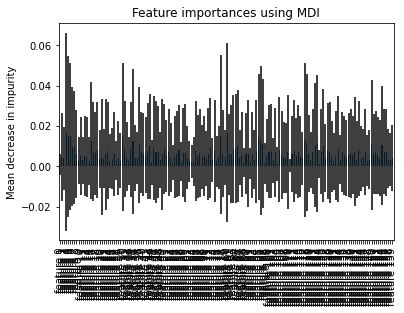

In [77]:
std = np.std([tree.feature_importances_ for tree in M1_2.estimators_], axis=0)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

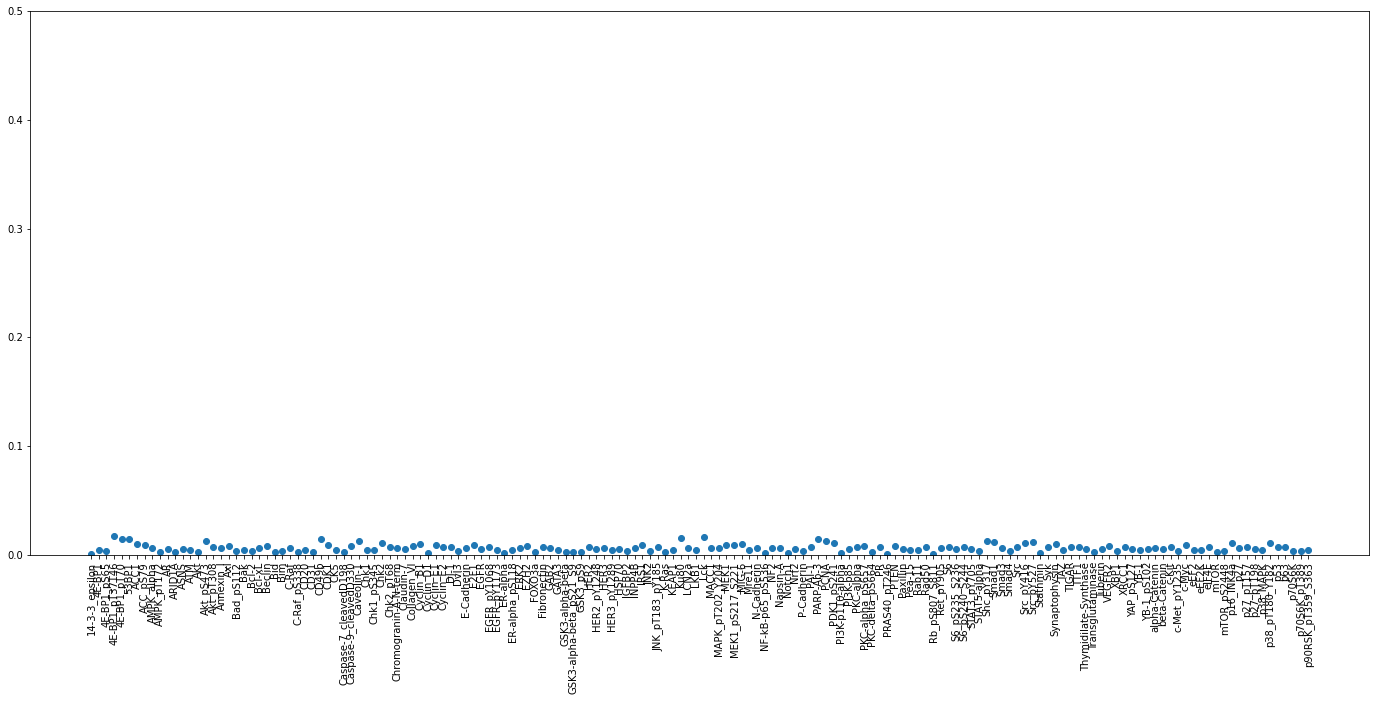

In [61]:
fig, ax = plt.subplots()
plt.plot(M1_2.feature_importances_, 'o')
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylim(0, 0.5)
fig.show
fig.set_size_inches(24, 10)
fig.savefig('RPPA.png', bbox_inches='tight')

### SVC

In [174]:
M1_3 = SVC()
M1_3.fit(X_train, y_train)
M1_3_y_pred = M1_3.predict(X_test)
performance_metrics(M1_3, y_test, M1_3_y_pred)

=== Confusion Matrix ===
[[18  5]
 [18  2]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.78      0.61        23
           1       0.29      0.10      0.15        20

    accuracy                           0.47        43
   macro avg       0.39      0.44      0.38        43
weighted avg       0.40      0.47      0.40        43

=== Mean AUC Score ===
0.493
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.123
=== F1 Score (best value at 1 and worst score at 0) ===
0.148
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.159
=== Sensitivity ===
0.100
=== Specificity ===
0.783


### ExtraTrees

In [33]:
M1_4 = ExtraTreesClassifier(random_state=0)
M1_4.fit(X_train, y_train)
M1_4_y_pred = M1_4.predict(X_test)
performance_metrics(M1_4, y_test, M1_4_y_pred)

=== Confusion Matrix ===
[[20  4]
 [16  3]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.56      0.83      0.67        24
           1       0.43      0.16      0.23        19

    accuracy                           0.53        43
   macro avg       0.49      0.50      0.45        43
weighted avg       0.50      0.53      0.47        43

=== Mean AUC Score ===
0.491
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.009
=== F1 Score (best value at 1 and worst score at 0) ===
0.231
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.012
=== Sensitivity ===
0.158
=== Specificity ===
0.833


### DecisionTree

In [34]:
M1_5 = DecisionTreeClassifier(random_state=0)
M1_5.fit(X_train, y_train)
M1_5_y_pred = M1_5.predict(X_test)
performance_metrics(M1_5, y_test, M1_5_y_pred)

=== Confusion Matrix ===
[[14 10]
 [12  7]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.54      0.58      0.56        24
           1       0.41      0.37      0.39        19

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.47        43
weighted avg       0.48      0.49      0.48        43

=== Mean AUC Score ===
0.509
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.049
=== F1 Score (best value at 1 and worst score at 0) ===
0.389
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.049
=== Sensitivity ===
0.368
=== Specificity ===
0.583


### KNN

In [51]:
M1_6 = KNeighborsClassifier()
M1_6.fit(X_train, y_train)
M1_6_y_pred = M1_6.predict(X_test)
performance_metrics(M1_6, y_test, M1_6_y_pred)

=== Confusion Matrix ===
[[ 8 12]
 [10 13]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.44      0.40      0.42        20
           1       0.52      0.57      0.54        23

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.48        43
weighted avg       0.48      0.49      0.49        43

=== Mean AUC Score ===
0.493
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.035
=== F1 Score (best value at 1 and worst score at 0) ===
0.542
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.035
=== Sensitivity ===
0.565
=== Specificity ===
0.400


### Naive Bayes

In [63]:
M1_7 = GaussianNB()
M1_7.fit(X_train, y_train)
M1_7_y_pred = M1_7.predict(X_test)
performance_metrics(M1_7, y_test, M1_7_y_pred)

=== Confusion Matrix ===
[[21  7]
 [14  1]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        28
           1       0.12      0.07      0.09        15

    accuracy                           0.51        43
   macro avg       0.36      0.41      0.38        43
weighted avg       0.43      0.51      0.46        43

=== Mean AUC Score ===
0.460
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.206
=== F1 Score (best value at 1 and worst score at 0) ===
0.087
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.225
=== Sensitivity ===
0.067
=== Specificity ===
0.750


### Logistic Regression

In [157]:
from sklearn.linear_model import LogisticRegression

M1_8 = LogisticRegression()
M1_8.fit(X_train, y_train)
M1_8_y_pred = M1_8.predict(X_test)
performance_metrics(M1_8, y_test, M1_8_y_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

=== Confusion Matrix ===
[[15  7]
 [15  6]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.68      0.58        22
           1       0.46      0.29      0.35        21

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.46        43
weighted avg       0.48      0.49      0.47        43



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

=== Mean AUC Score ===
0.554
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.033
=== F1 Score (best value at 1 and worst score at 0) ===
0.353
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.035
=== Sensitivity ===
0.286
=== Specificity ===
0.682


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Ridge

In [149]:
M1_9 = RidgeClassifier()
M1_9.fit(X_train, y_train)
M1_9_y_pred = M1_9.predict(X_test)
performance_metrics(M1_9, y_test, M1_9_y_pred)

=== Confusion Matrix ===
[[14  9]
 [13  7]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.52      0.61      0.56        23
           1       0.44      0.35      0.39        20

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.47        43
weighted avg       0.48      0.49      0.48        43

=== Mean AUC Score ===
0.547
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.042
=== F1 Score (best value at 1 and worst score at 0) ===
0.389
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.043
=== Sensitivity ===
0.350
=== Specificity ===
0.609


### ElasticNet

In [85]:
M1_10 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)
M1_10.fit(X_train, y_train)
M1_10_y_pred = M1_10.predict(X_test)
performance_metrics(M1_10, y_test, M1_10_y_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== Confusion Matrix ===
[[ 9 13]
 [10 11]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.47      0.41      0.44        22
           1       0.46      0.52      0.49        21

    accuracy                           0.47        43
   macro avg       0.47      0.47      0.46        43
weighted avg       0.47      0.47      0.46        43



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== Mean AUC Score ===
0.553
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.067
=== F1 Score (best value at 1 and worst score at 0) ===
0.489
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.068
=== Sensitivity ===
0.524
=== Specificity ===
0.409


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### LDA

In [98]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions, using the transform method
M1_11 = LinearDiscriminantAnalysis()
M1_11.fit(X_train, y_train)
M1_11_y_pred = M1_11.predict(X_test)
performance_metrics(M1_11, y_test, M1_11_y_pred)

=== Confusion Matrix ===
[[12 14]
 [ 9  8]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.57      0.46      0.51        26
           1       0.36      0.47      0.41        17

    accuracy                           0.47        43
   macro avg       0.47      0.47      0.46        43
weighted avg       0.49      0.47      0.47        43

=== Mean AUC Score ===
0.563
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.065
=== F1 Score (best value at 1 and worst score at 0) ===
0.410
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.066
=== Sensitivity ===
0.471
=== Specificity ===
0.462


### ANN

In [80]:
# !pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
# keras to create ANN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [84]:
def create_baseline():
 # create model
 model = Sequential()
 model.add(Dense(160, input_shape=(160,), activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

In [85]:
# evaluate model with standardized dataset
estimator = KerasClassifier(model=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 53.81% (9.48%)


### Stacked generalisation

In [ ]:
from sklearn.ensemble import StackingClassifier

## model comparisons

# M2: DNAm predicted protein data.
Measured from both primary tumours and adjacent solid normal tissue samples from TCGA HNSC participants. Prediction on the `PFI` cancer-related outcome.

## prior analysis

In [ ]:
m_df = pd.read_csv("/content/sample_data/m/clinical.txt", sep="\t")
m_df

FileNotFoundError: ignored

In [ ]:
# row = protein, column = DNAm, cell = EpiScore
pp_df = pd.read_csv("/content/sample_data/predicted-proteins.txt", sep="\t")
pp_df

,AA8J-01,4074-01,4075-01,4076-01,4077-01,4078-01,5149-01,5151-01,5152-01,5153-01,...,A7JH-01,A7JJ-01,A7JK-01,A7JO-01,A7JS-01,A7JT-01,A7JV-01,A6WW-01,A7GZ-01,A7H4-01
ADAMTS,0.019225,0.050171,-0.000711,-0.000291,0.005409,0.016510,0.008386,0.016878,0.020666,0.015039,...,-0.001770,0.028181,0.014458,0.015173,0.010884,0.007625,0.021397,0.000583,0.012425,0.034156
Adiponectin,0.026065,-0.008686,-0.016177,0.023861,0.031038,0.046269,0.030693,0.005258,0.010245,0.041478,...,0.029619,0.004182,-0.006665,0.019841,-0.001787,0.041062,0.049281,0.024771,0.022825,0.010230
Afamin,0.001606,0.025514,0.021724,-0.001979,0.003346,0.022871,-0.000927,-0.000347,0.007869,0.004957,...,0.027874,0.003357,0.009719,0.010313,0.002521,0.011060,0.001647,0.016424,0.022647,0.014298
Alpha-L-iduronidase,0.117279,0.101106,0.121121,0.136527,0.128097,0.123318,0.122756,0.127024,0.125814,0.113554,...,0.117941,0.125381,0.118154,0.122593,0.134517,0.128696,0.133702,0.125917,0.114550,0.110430
Aminoacylase-1,-0.234582,-0.147709,-0.247137,-0.264208,-0.281698,-0.231860,-0.219663,-0.269984,-0.213892,-0.270272,...,-0.149098,-0.234988,-0.274156,-0.241945,-0.195764,-0.258324,-0.273825,-0.293964,-0.229442,-0.216667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trypsin-2,-0.054481,-0.040917,-0.022875,-0.030390,-0.063056,-0.036217,-0.037884,-0.056481,-0.041795,-0.103839,...,-0.029659,-0.076842,-0.075821,-0.060179,-0.016885,-0.065416,-0.051754,-0.099728,-0.038246,-0.077954
Tryptase_beta-2,-0.122685,-0.086487,-0.101726,-0.140230,-0.125230,-0.150438,-0.111571,-0.104718,-0.112273,-0.098592,...,-0.107906,-0.104093,-0.116665,-0.107937,-0.119735,-0.109542,-0.088129,-0.123679,-0.082331,-0.071884
VCAM1,0.046360,0.058890,0.063551,0.045601,0.046468,0.037457,0.058761,0.058130,0.054006,0.061548,...,0.055550,0.045495,0.053389,0.050480,0.054002,0.057414,0.052048,0.063842,0.041402,0.044453
VEGFA,0.088700,0.101531,0.141756,0.150687,0.120568,0.140118,0.126588,0.114610,0.103030,0.115030,...,0.093333,0.091653,0.105924,0.108557,0.110328,0.124874,0.104976,0.109814,0.107977,0.098743


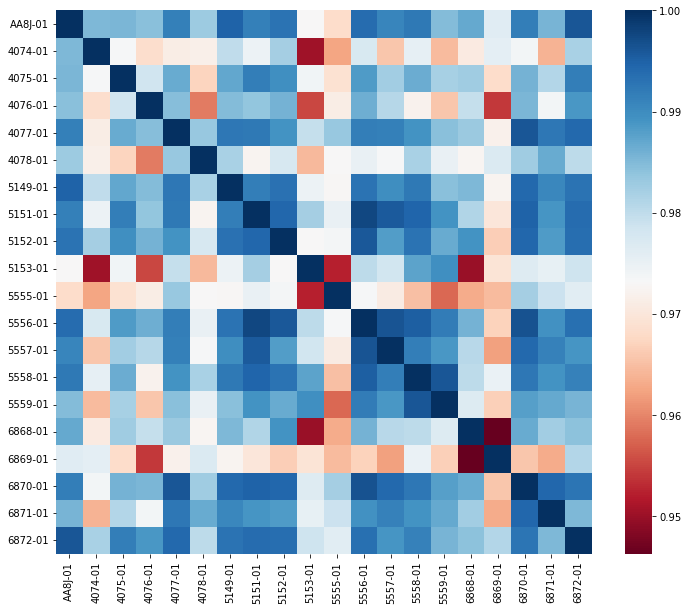

In [ ]:
fig, ax = plt.subplots()
npp_df = pp_df.iloc[:20,:20]
sns.heatmap(npp_df.corr(), cmap='RdBu')
fig.show
fig.set_size_inches(12, 10)
fig.savefig('PP.png', bbox_inches='tight')

In [ ]:
# X = 
# y =

## models

In [ ]:
# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

### LinearSVC

In [ ]:
from sklearn.svm import LinearSVC

M2 = LinearSVC()

In [ ]:
M2.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
M2_y_pred = M2.predict(X_test)

### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc

# default is bootstrap set to True
M2_2 = rfc(random_state=0)
M2_2.fit(X_train, y_train)
M2_2_y_pred = M2_2.predict(X_test)
performance_metrics(M2_2, y_test, M2_2_y_pred)

=== Confusion Matrix ===
[[18  6]
 [14  5]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.56      0.75      0.64        24
           1       0.45      0.26      0.33        19

    accuracy                           0.53        43
   macro avg       0.51      0.51      0.49        43
weighted avg       0.51      0.53      0.51        43

=== Mean AUC Score ===
0.508
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
0.014
=== F1 Score (best value at 1 and worst score at 0) ===
0.333
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
0.015
=== Sensitivity ===
0.263
=== Specificity ===
0.750


In [ ]:
importances = M2_2.feature_importances_

Text(0, 0.5, 'Mean decrease in impurity')

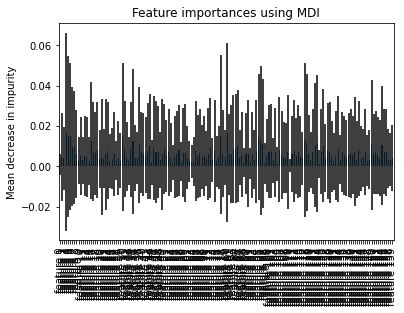

In [ ]:
std = np.std([tree.feature_importances_ for tree in M2_2.estimators_], axis=0)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

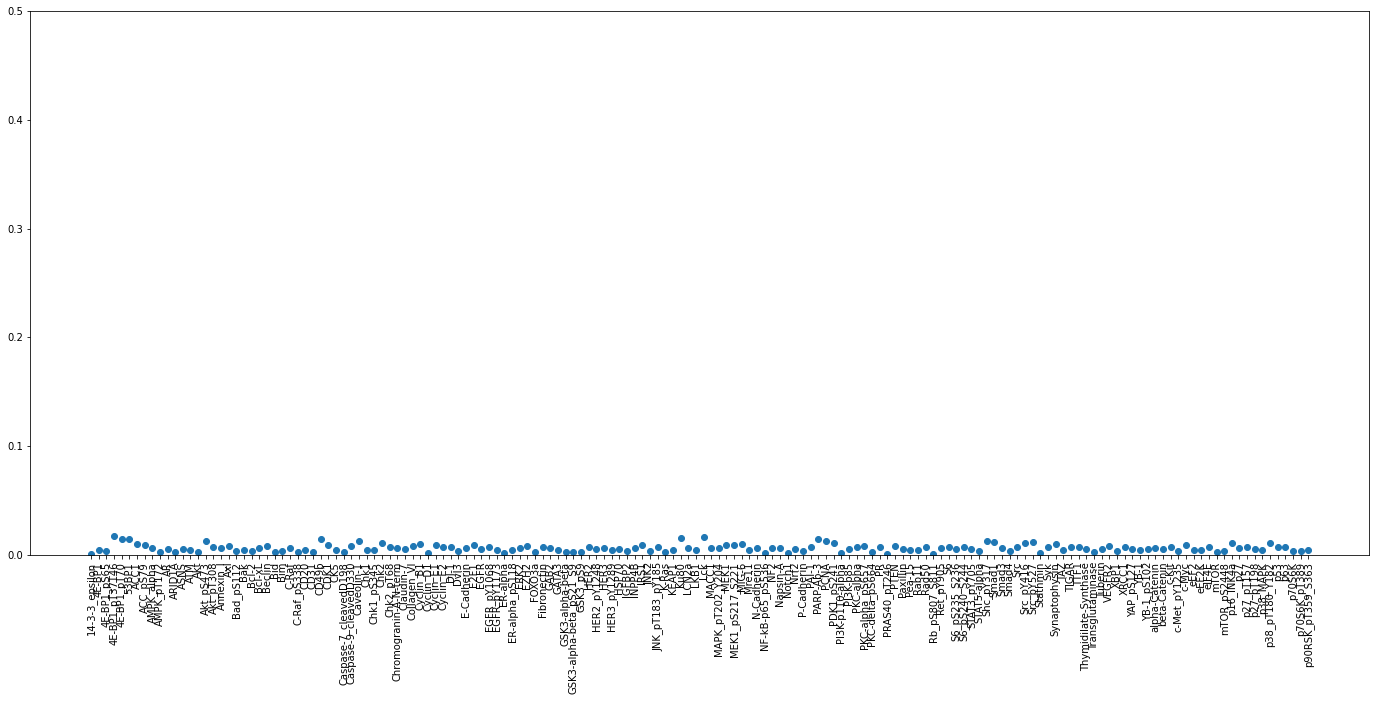

In [ ]:
fig, ax = plt.subplots()
plt.plot(M2_2.feature_importances_, 'o')
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylim(0, 0.5)
fig.show
fig.set_size_inches(24, 10)
fig.savefig('RPPA.png', bbox_inches='tight')

### SVC

In [ ]:
from sklearn.svm import SVC

M2_3 = SVC()
M2_3.fit(X_train, y_train)
M2_3_y_pred = M2_3.predict(X_test)
performance_metrics(M2_3, y_test, M2_3_y_pred)

=== Confusion Matrix ===
[[18  5]
 [18  2]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.78      0.61        23
           1       0.29      0.10      0.15        20

    accuracy                           0.47        43
   macro avg       0.39      0.44      0.38        43
weighted avg       0.40      0.47      0.40        43

=== Mean AUC Score ===
0.493
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.123
=== F1 Score (best value at 1 and worst score at 0) ===
0.148
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.159
=== Sensitivity ===
0.100
=== Specificity ===
0.783


### ExtraTrees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

M2_4 = ExtraTreesClassifier(random_state=0)
M2_4.fit(X_train, y_train)
M2_4_y_pred = M2_4.predict(X_test)
performance_metrics(M2_4, y_test, M2_4_y_pred)

=== Confusion Matrix ===
[[20  4]
 [16  3]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.56      0.83      0.67        24
           1       0.43      0.16      0.23        19

    accuracy                           0.53        43
   macro avg       0.49      0.50      0.45        43
weighted avg       0.50      0.53      0.47        43

=== Mean AUC Score ===
0.491
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.009
=== F1 Score (best value at 1 and worst score at 0) ===
0.231
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.012
=== Sensitivity ===
0.158
=== Specificity ===
0.833


### DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

M2_5 = DecisionTreeClassifier(random_state=0)
M2_5.fit(X_train, y_train)
M2_5_y_pred = M2_5.predict(X_test)
performance_metrics(M2_5, y_test, M2_5_y_pred)

=== Confusion Matrix ===
[[14 10]
 [12  7]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.54      0.58      0.56        24
           1       0.41      0.37      0.39        19

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.47        43
weighted avg       0.48      0.49      0.48        43

=== Mean AUC Score ===
0.509
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.049
=== F1 Score (best value at 1 and worst score at 0) ===
0.389
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.049
=== Sensitivity ===
0.368
=== Specificity ===
0.583


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

M2_6 = KNeighborsClassifier()
M2_6.fit(X_train, y_train)
M2_6_y_pred = M2_6.predict(X_test)
performance_metrics(M2_6, y_test, M2_6_y_pred)

=== Confusion Matrix ===
[[ 8 12]
 [10 13]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.44      0.40      0.42        20
           1       0.52      0.57      0.54        23

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.48        43
weighted avg       0.48      0.49      0.49        43

=== Mean AUC Score ===
0.493
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.035
=== F1 Score (best value at 1 and worst score at 0) ===
0.542
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.035
=== Sensitivity ===
0.565
=== Specificity ===
0.400


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

M2_7 = BernoulliNB()
M2_7.fit(X_train, y_train)
M2_7_y_pred = M2_7.predict(X_test)
performance_metrics(M2_7, y_test, M2_7_y_pred)

=== Confusion Matrix ===
[[21  7]
 [14  1]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        28
           1       0.12      0.07      0.09        15

    accuracy                           0.51        43
   macro avg       0.36      0.41      0.38        43
weighted avg       0.43      0.51      0.46        43

=== Mean AUC Score ===
0.460
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.206
=== F1 Score (best value at 1 and worst score at 0) ===
0.087
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.225
=== Sensitivity ===
0.067
=== Specificity ===
0.750


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

M2_8 = LogisticRegression()
M2_8.fit(X_train, y_train)
M2_8_y_pred = M2_8.predict(X_test)
performance_metrics(M2_8, y_test, M2_8_y_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

=== Confusion Matrix ===
[[15  7]
 [15  6]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.68      0.58        22
           1       0.46      0.29      0.35        21

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.46        43
weighted avg       0.48      0.49      0.47        43



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

=== Mean AUC Score ===
0.554
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.033
=== F1 Score (best value at 1 and worst score at 0) ===
0.353
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.035
=== Sensitivity ===
0.286
=== Specificity ===
0.682


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Ridge

In [ ]:
from sklearn.linear_model import RidgeClassifier

M2_9 = RidgeClassifier()
M2_9.fit(X_train, y_train)
M2_9_y_pred = M2_9.predict(X_test)
performance_metrics(M2_9, y_test, M2_9_y_pred)

=== Confusion Matrix ===
[[14  9]
 [13  7]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.52      0.61      0.56        23
           1       0.44      0.35      0.39        20

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.47        43
weighted avg       0.48      0.49      0.48        43

=== Mean AUC Score ===
0.547
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.042
=== F1 Score (best value at 1 and worst score at 0) ===
0.389
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.043
=== Sensitivity ===
0.350
=== Specificity ===
0.609


### ElasticNet

In [ ]:
M2_10 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)
M2_10.fit(X_train, y_train)
M2_10_y_pred = M2_10.predict(X_test)
performance_metrics(M2_10, y_test, M2_10_y_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== Confusion Matrix ===
[[ 9 13]
 [10 11]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.47      0.41      0.44        22
           1       0.46      0.52      0.49        21

    accuracy                           0.47        43
   macro avg       0.47      0.47      0.46        43
weighted avg       0.47      0.47      0.46        43



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== Mean AUC Score ===
0.553
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.067
=== F1 Score (best value at 1 and worst score at 0) ===
0.489
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.068
=== Sensitivity ===
0.524
=== Specificity ===
0.409


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions, using the transform method
M2_11 = LinearDiscriminantAnalysis()
M2_11.fit(X_train, y_train)
M2_11_y_pred = M2_11.predict(X_test)
performance_metrics(M2_11, y_test, M2_11_y_pred)

=== Confusion Matrix ===
[[12 14]
 [ 9  8]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.57      0.46      0.51        26
           1       0.36      0.47      0.41        17

    accuracy                           0.47        43
   macro avg       0.47      0.47      0.46        43
weighted avg       0.49      0.47      0.47        43

=== Mean AUC Score ===
0.563
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.065
=== F1 Score (best value at 1 and worst score at 0) ===
0.410
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.066
=== Sensitivity ===
0.471
=== Specificity ===
0.462


### ANN

In [ ]:
# keras to create ANN

### Stacked generalisation

In [ ]:
from sklearn.ensemble import StackingClassifier

# M3: DNAm predicted protein data.
Measured from both primary tumours and adjacent solid normal tissue samples from TCGA HNSC participants. Prediction on the `tumour.or.normal` cancer-related outcome.

### prior analysis

In [ ]:
m2_df = pd.read_csv("/content/sample_data/m/clinical.txt", sep="\t")
m2_df

,participant,female,histology,age.at.diagnosis,ethnicity,race,positive.lymphnodes,stage,tnm.m.category,tnm.n.category,...,normal.cells.percent,stromal.cells.percent,tumor.cells.percent,pfi,pfi.time,dfi,dfi.time,tissue,participant.tissue,tumor.or.normal
0,4074,False,head & neck squamous cell carcinoma,69.0,not hispanic or latino,white,5.0,stage iva,m0,n2,...,0.0,10.0,87.0,1,396.0,NaN,NaN,1,4074-01,tumor
1,4075,False,head & neck squamous cell carcinoma,49.0,not hispanic or latino,black or african american,0.0,stage iii,m0,n0,...,0.0,15.0,70.0,1,236.0,NaN,NaN,1,4075-01,tumor
2,4076,False,head & neck squamous cell carcinoma,39.0,not hispanic or latino,white,NaN,NaN,NaN,NaN,...,0.0,3.0,95.0,1,286.0,NaN,NaN,1,4076-01,tumor
3,4077,True,head & neck squamous cell carcinoma,45.0,not hispanic or latino,white,NaN,stage iva,m0,n0,...,0.0,10.0,85.0,1,1134.0,NaN,NaN,1,4077-01,tumor
4,4078,False,head & neck squamous cell carcinoma,83.0,not hispanic or latino,white,4.0,NaN,NaN,NaN,...,0.0,15.0,80.0,1,276.0,NaN,NaN,1,4078-01,tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,A92M,False,head & neck squamous cell carcinoma,52.0,not hispanic or latino,black or african american,4.0,stage iva,NaN,n2,...,0.0,0.0,100.0,1,417.0,NaN,NaN,1,A92M-01,tumor
574,A92N,False,head & neck squamous cell carcinoma,79.0,not hispanic or latino,black or african american,6.0,stage iva,NaN,n2,...,0.0,10.0,90.0,1,46.0,NaN,NaN,1,A92N-01,tumor
575,AA3J,False,head & neck squamous cell carcinoma basaloid type,69.0,not hispanic or latino,black or african american,NaN,stage i,m0,n0,...,0.0,20.0,80.0,0,466.0,0.0,466.0,1,AA3J-01,tumor
576,AA3K,False,head & neck squamous cell carcinoma,60.0,not hispanic or latino,black or african american,4.0,stage iva,NaN,n2,...,0.0,25.0,75.0,0,253.0,NaN,NaN,1,AA3K-01,tumor


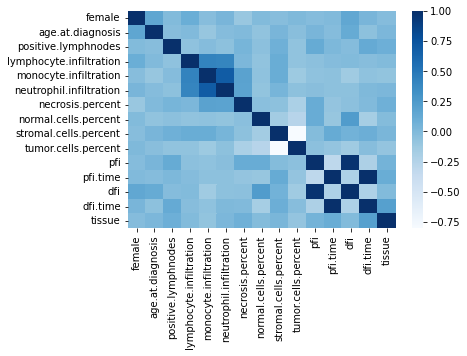

In [ ]:
sns.heatmap(m2_df.corr(), cmap="Blues")

In [ ]:
m2_df = m2_df.dropna(subset=['tumor.or.normal'])
m2_df

NameError: ignored

In [ ]:
m2_df['tumor.or.normal'].replace(['tumor', 'normal'],
                        [0, 1], inplace=True)
y = m2_df['tumor.or.normal']
print(m2_df)

# for i in range(len(m2_df)):
#   if y.iloc[i] == 'tumor':
#     y.iloc[i] = 1
#   elif y.iloc[i] == 'normal':
#     y.iloc[i] = 0
#   else:
#     print(i)

# X =
y = m2_df['tumor.or.normal']
# print(X.head)
print(y)

    participant  female                                          histology  \
0          4074   False                head & neck squamous cell carcinoma   
1          4075   False                head & neck squamous cell carcinoma   
2          4076   False                head & neck squamous cell carcinoma   
3          4077    True                head & neck squamous cell carcinoma   
4          4078   False                head & neck squamous cell carcinoma   
..          ...     ...                                                ...   
573        A92M   False                head & neck squamous cell carcinoma   
574        A92N   False                head & neck squamous cell carcinoma   
575        AA3J   False  head & neck squamous cell carcinoma basaloid type   
576        AA3K   False                head & neck squamous cell carcinoma   
577        AA8J   False                head & neck squamous cell carcinoma   

     age.at.diagnosis               ethnicity                  

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## models

In [ ]:
# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

### LinearSVC

In [ ]:
from sklearn.svm import LinearSVC

M3 = LinearSVC()

In [ ]:
M3.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
M3_y_pred = M3.predict(X_test)

### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc

# default is bootstrap set to True
M3_2 = rfc(random_state=0)
M3_2.fit(X_train, y_train)
M3_2_y_pred = M3_2.predict(X_test)
performance_metrics(M3_2, y_test, M3_2_y_pred)

=== Confusion Matrix ===
[[18  6]
 [14  5]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.56      0.75      0.64        24
           1       0.45      0.26      0.33        19

    accuracy                           0.53        43
   macro avg       0.51      0.51      0.49        43
weighted avg       0.51      0.53      0.51        43

=== Mean AUC Score ===
0.508
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
0.014
=== F1 Score (best value at 1 and worst score at 0) ===
0.333
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
0.015
=== Sensitivity ===
0.263
=== Specificity ===
0.750


In [ ]:
importances = M3_2.feature_importances_

Text(0, 0.5, 'Mean decrease in impurity')

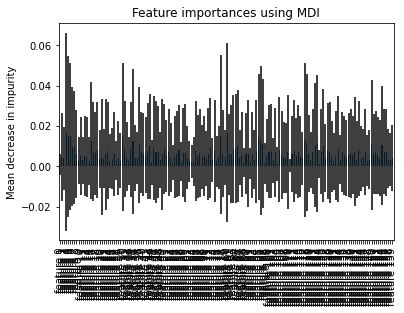

In [ ]:
std = np.std([tree.feature_importances_ for tree in M3_2.estimators_], axis=0)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

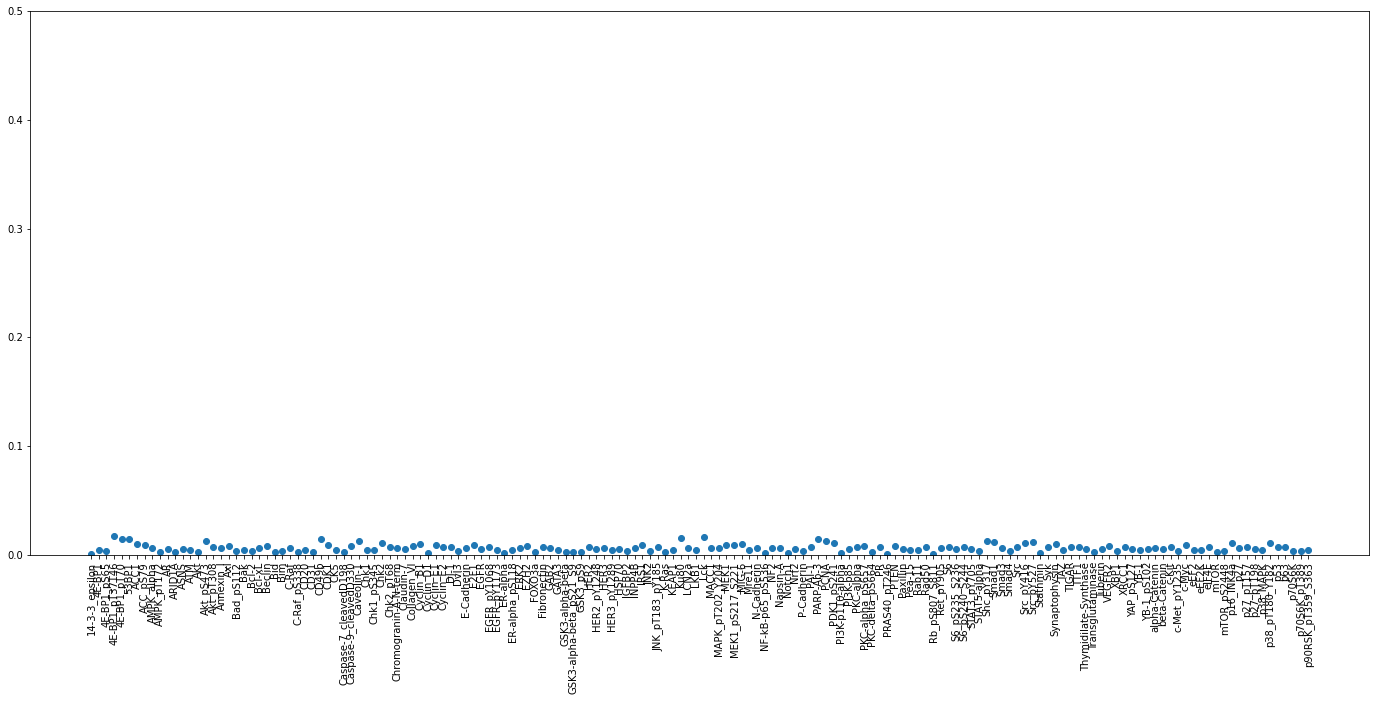

In [ ]:
fig, ax = plt.subplots()
plt.plot(M3_2.feature_importances_, 'o')
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylim(0, 0.5)
fig.show
fig.set_size_inches(24, 10)
fig.savefig('RPPA.png', bbox_inches='tight')

### SVC

In [ ]:
from sklearn.svm import SVC

M3_3 = SVC()
M3_3.fit(X_train, y_train)
M3_3_y_pred = M3_3.predict(X_test)
performance_metrics(M3_3, y_test, M3_3_y_pred)

=== Confusion Matrix ===
[[18  5]
 [18  2]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.78      0.61        23
           1       0.29      0.10      0.15        20

    accuracy                           0.47        43
   macro avg       0.39      0.44      0.38        43
weighted avg       0.40      0.47      0.40        43

=== Mean AUC Score ===
0.493
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.123
=== F1 Score (best value at 1 and worst score at 0) ===
0.148
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.159
=== Sensitivity ===
0.100
=== Specificity ===
0.783


### ExtraTrees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

M3_4 = ExtraTreesClassifier(random_state=0)
M3_4.fit(X_train, y_train)
M3_4_y_pred = M3_4.predict(X_test)
performance_metrics(M3_4, y_test, M3_4_y_pred)

=== Confusion Matrix ===
[[20  4]
 [16  3]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.56      0.83      0.67        24
           1       0.43      0.16      0.23        19

    accuracy                           0.53        43
   macro avg       0.49      0.50      0.45        43
weighted avg       0.50      0.53      0.47        43

=== Mean AUC Score ===
0.491
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.009
=== F1 Score (best value at 1 and worst score at 0) ===
0.231
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.012
=== Sensitivity ===
0.158
=== Specificity ===
0.833


### DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

M3_5 = DecisionTreeClassifier(random_state=0)
M3_5.fit(X_train, y_train)
M3_5_y_pred = M3_5.predict(X_test)
performance_metrics(M3_5, y_test, M3_5_y_pred)

=== Confusion Matrix ===
[[14 10]
 [12  7]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.54      0.58      0.56        24
           1       0.41      0.37      0.39        19

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.47        43
weighted avg       0.48      0.49      0.48        43

=== Mean AUC Score ===
0.509
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.049
=== F1 Score (best value at 1 and worst score at 0) ===
0.389
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.049
=== Sensitivity ===
0.368
=== Specificity ===
0.583


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

M3_6 = KNeighborsClassifier()
M3_6.fit(X_train, y_train)
M3_6_y_pred = M3_6.predict(X_test)
performance_metrics(M3_6, y_test, M3_6_y_pred)

=== Confusion Matrix ===
[[ 8 12]
 [10 13]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.44      0.40      0.42        20
           1       0.52      0.57      0.54        23

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.48        43
weighted avg       0.48      0.49      0.49        43

=== Mean AUC Score ===
0.493
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.035
=== F1 Score (best value at 1 and worst score at 0) ===
0.542
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.035
=== Sensitivity ===
0.565
=== Specificity ===
0.400


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

M3_7 = BernoulliNB()
M3_7.fit(X_train, y_train)
M3_7_y_pred = M3_7.predict(X_test)
performance_metrics(M3_7, y_test, M3_7_y_pred)

=== Confusion Matrix ===
[[21  7]
 [14  1]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        28
           1       0.12      0.07      0.09        15

    accuracy                           0.51        43
   macro avg       0.36      0.41      0.38        43
weighted avg       0.43      0.51      0.46        43

=== Mean AUC Score ===
0.460
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.206
=== F1 Score (best value at 1 and worst score at 0) ===
0.087
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.225
=== Sensitivity ===
0.067
=== Specificity ===
0.750


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

M3_8 = LogisticRegression()
M3_8.fit(X_train, y_train)
M3_8_y_pred = M3_8.predict(X_test)
performance_metrics(M3_8, y_test, M3_8_y_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

=== Confusion Matrix ===
[[15  7]
 [15  6]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.68      0.58        22
           1       0.46      0.29      0.35        21

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.46        43
weighted avg       0.48      0.49      0.47        43



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

=== Mean AUC Score ===
0.554
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.033
=== F1 Score (best value at 1 and worst score at 0) ===
0.353
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.035
=== Sensitivity ===
0.286
=== Specificity ===
0.682


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Ridge

In [ ]:
from sklearn.linear_model import RidgeClassifier

M3_9 = RidgeClassifier()
M3_9.fit(X_train, y_train)
M3_9_y_pred = M3_9.predict(X_test)
performance_metrics(M3_9, y_test, M3_9_y_pred)

=== Confusion Matrix ===
[[14  9]
 [13  7]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.52      0.61      0.56        23
           1       0.44      0.35      0.39        20

    accuracy                           0.49        43
   macro avg       0.48      0.48      0.47        43
weighted avg       0.48      0.49      0.48        43

=== Mean AUC Score ===
0.547
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.042
=== F1 Score (best value at 1 and worst score at 0) ===
0.389
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.043
=== Sensitivity ===
0.350
=== Specificity ===
0.609


### ElasticNet

In [ ]:
M3_10 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)
M3_10.fit(X_train, y_train)
M3_10_y_pred = M3_10.predict(X_test)
performance_metrics(M3_10, y_test, M3_10_y_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== Confusion Matrix ===
[[ 9 13]
 [10 11]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.47      0.41      0.44        22
           1       0.46      0.52      0.49        21

    accuracy                           0.47        43
   macro avg       0.47      0.47      0.46        43
weighted avg       0.47      0.47      0.46        43



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== Mean AUC Score ===
0.553
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.067
=== F1 Score (best value at 1 and worst score at 0) ===
0.489
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.068
=== Sensitivity ===
0.524
=== Specificity ===
0.409


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions, using the transform method
M3_11 = LinearDiscriminantAnalysis()
M3_11.fit(X_train, y_train)
M3_11_y_pred = M3_11.predict(X_test)
performance_metrics(M3_11, y_test, M3_11_y_pred)

=== Confusion Matrix ===
[[12 14]
 [ 9  8]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.57      0.46      0.51        26
           1       0.36      0.47      0.41        17

    accuracy                           0.47        43
   macro avg       0.47      0.47      0.46        43
weighted avg       0.49      0.47      0.47        43

=== Mean AUC Score ===
0.563
=== Kappa Score (1 means complete agreement, zero or lower means chance agreement) ===
-0.065
=== F1 Score (best value at 1 and worst score at 0) ===
0.410
=== MCC (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction) ===
-0.066
=== Sensitivity ===
0.471
=== Specificity ===
0.462


### ANN

In [ ]:
# keras to create ANN

### Stacked generalisation

In [ ]:
from sklearn.ensemble import StackingClassifier